In [146]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from scipy.stats import pearsonr, spearmanr
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os


#import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [147]:
task = 'motor'

###### CHOOSE SUBJECTS

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

#subjects_to_process = find_existing_subjects(task = task, period = 'pre',erp_window=erp_window,freq_high=freq_high) #subs that exist in pre should exist in post
#subjects_to_process = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
subjects_to_process = good_motor_subjects

##### CHOOSE CHANNELS
#ch_to_process = 'all'
ch_to_process = ch_index(['Cz'])



wavelet_params = {
    'fs' :128 , # example sampling frequency in Hz
    'centerfreq' : 1 ,
    'bandwidth': 1.5,
    'level': 10,
    'scale_values':[6, 150, 40]
}

mtrf_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_mTRF_data_30Hz'
wavelet_dir = f"./wavelet_{task}_Cz"

print('processing subjects:', subjects_to_process)
print('processing channels:', ch_to_process)

mne.set_log_level('CRITICAL')

processing subjects: ['01', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20']
processing channels: [47]


## Single subject test

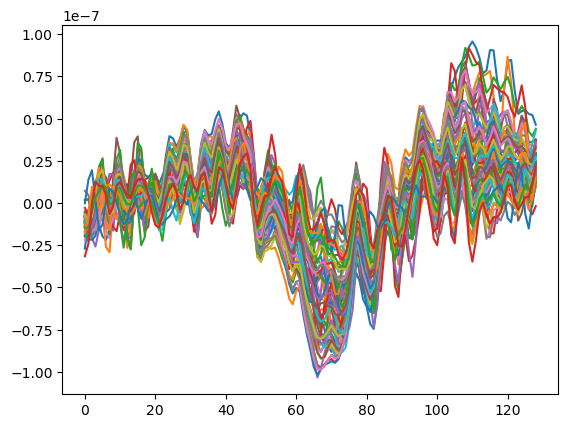

In [148]:
sub = '08'
period = 'pre'
task = 'motor'
mtrf_weights = loadmat(os.path.join(mtrf_path, f'mTRFweights_{task}_{period}_{sub}.mat'))['weights'][0]
plt.plot(mtrf_weights);


Correlation matrix

<Axes: >

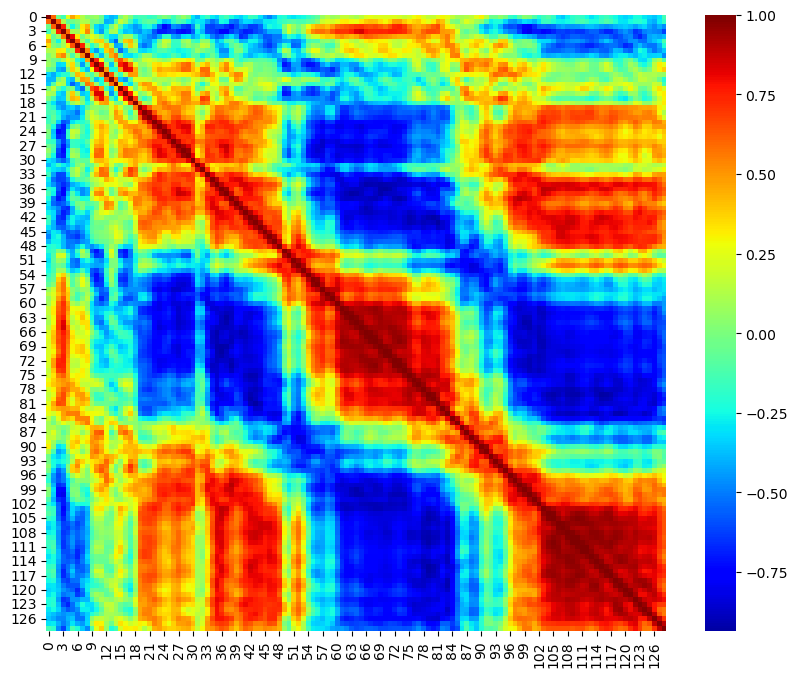

In [149]:
corr_ch = np.corrcoef(mtrf_weights)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_ch, annot=False, cmap="jet", center=0)


Average over channels mtrf

Text(0.5, 1.0, 'motor pre sub 08')

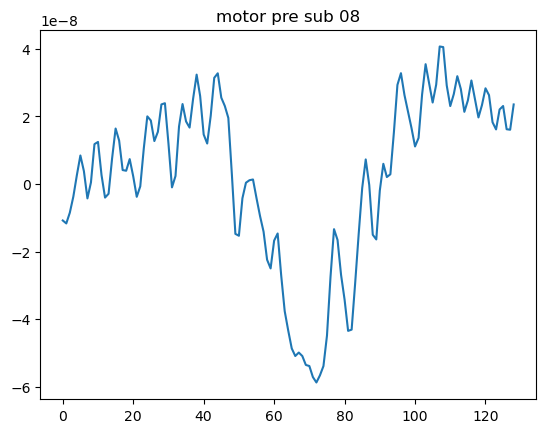

In [150]:
mtrf_weights_ave = np.mean(mtrf_weights, axis = 1)
plt.plot(mtrf_weights_ave)
plt.title(f'{task} {period} sub {sub}')

In [151]:
wavelet_params = {
    'fs' :128 , # example sampling frequency in Hz
    'centerfreq' : 1 ,
    'bandwidth': 1.5,
    'level': 10,
    'scale_values':[6, 150, 40]
}


In [152]:
cwtmatr, freqs, wavelet = morwav_trans(mtrf_weights_ave, 
                             centerfreq=wavelet_params['centerfreq'], 
                            bandwidth=wavelet_params['bandwidth'], 
                            scale_values=wavelet_params['scale_values'])

In [153]:
times = create_erp_times(-0.5, 0.5, 128)

Text(0.5, 1.0, 'motor pre sub 08')

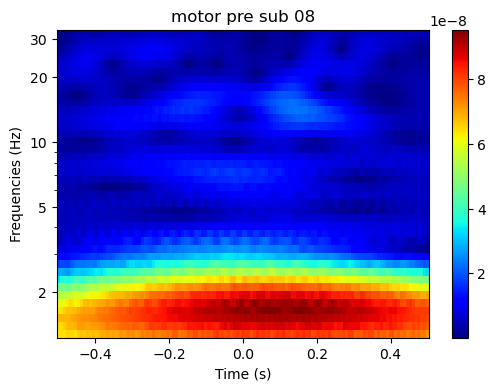

In [154]:
plot_scaleogram(cwtmatr, freqs, times)
plt.title(f'{task} {period} sub {sub}')

Correlation with phase shifts

In [155]:
corr_triu = np.triu(corr_ch)
corr_triu_abs = np.abs(corr_triu)
np.mean(corr_triu)

0.021291752766198355

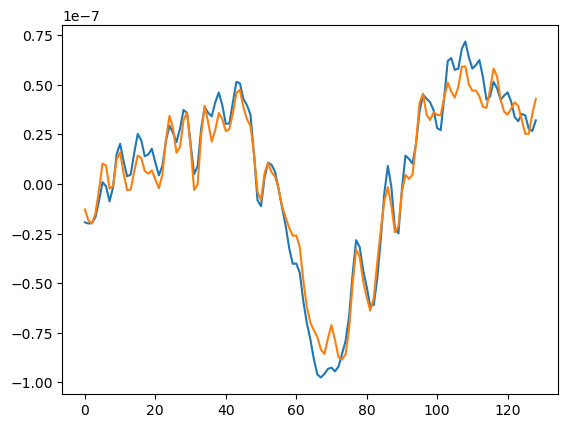

In [156]:
plt.plot(mtrf_weights[:, 3])
plt.plot(mtrf_weights[:, 39])

In [157]:
ch_names_64, _ = load_channels()

In [158]:
ch_index(['FCz'])

[46]

In [159]:
ch_names_64[39]

'F4'

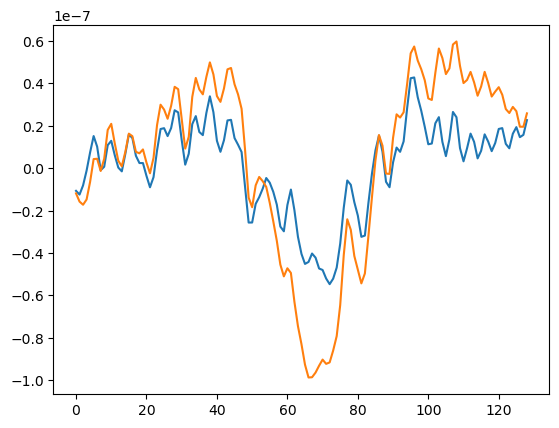

In [160]:
idx1 = 30
idx2 = 46

ch_1 = mtrf_weights[:, idx1]
ch_2 = mtrf_weights[:, idx2]
plt.plot(ch_1)
plt.plot(ch_2)

PearsonRResult(statistic=-0.07569015984120375, pvalue=0.4384215295469714)


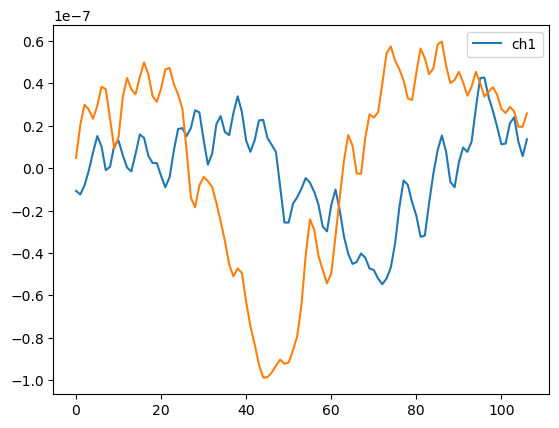

In [161]:
lag = 22

if lag < 0:
    # For negative lag, shift ch_2 to the left and trim ch_1 to match
    shifted_ch_2 = ch_2[:lag]  # Equivalent to ch_2[:-abs(lag)]
    shifted_ch_1 = ch_1[abs(lag):]  # Trim ch_1 to match shifted_ch_2
elif lag > 0:
    # For positive lag, shift ch_1 to the left and trim ch_2 to match
    shifted_ch_1 = ch_1[:-lag]  # Shift ch_1 left
    shifted_ch_2 = ch_2[lag:]  # Trim ch_2 to match shifted_ch_1
else:
    # No shift needed if lag is 0
    shifted_ch_1 = ch_1
    shifted_ch_2 = ch_2
print(pearsonr(shifted_ch_1, shifted_ch_2))
plt.plot(shifted_ch_1, label = 'ch1')
plt.plot(shifted_ch_2)
plt.legend()

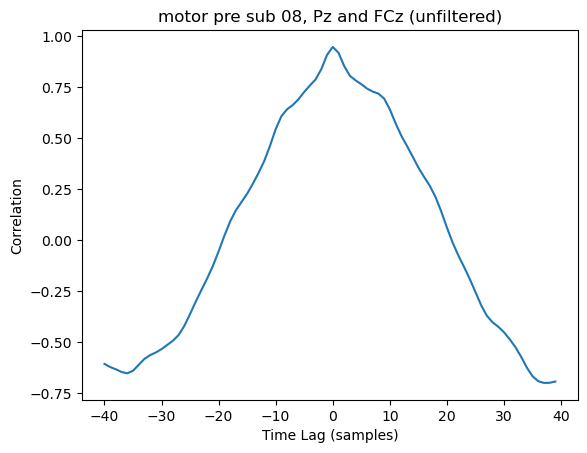

In [162]:
# Define the range of time lags (in samples)
time_lags = range(-40,40)
n_samples = ch_1.shape[0]
  # Example: from -50 to 50 samples
correlations = []
# Store correlation 
# Compute correlation for each time lag
for lag in time_lags:
    if lag < 0:
        # For negative lag, shift ch_2 to the left and trim ch_1 to match
        shifted_ch_2 = ch_2[:lag]  # Equivalent to ch_2[:-abs(lag)]
        shifted_ch_1 = ch_1[abs(lag):]  # Trim ch_1 to match shifted_ch_2
    elif lag > 0:
        # For positive lag, shift ch_1 to the left and trim ch_2 to match
        shifted_ch_1 = ch_1[:-lag]  # Shift ch_1 left
        shifted_ch_2 = ch_2[lag:]  # Trim ch_2 to match shifted_ch_1
    else:
        # No shift needed if lag is 0
        shifted_ch_1 = ch_1
        shifted_ch_2 = ch_2

    #plt.plot(shifted_ch_1, color = 'black')
    #plt.plot(shifted_ch_2, color = 'blue')
    # Compute Pearson correlation
    r, _ = pearsonr(shifted_ch_1, shifted_ch_2)
    
    correlations.append(r)

# Convert correlations to numpy array for further analysis
correlations = np.array(correlations)

# Plot the results
import matplotlib.pyplot as plt
plt.plot(time_lags, correlations)
plt.xlabel('Time Lag (samples)')
plt.ylabel('Correlation')
#plt.ylim(-8e-, 8e-5)
plt.title(f'{task} {period} sub {sub}, {ch_names_64[idx1]} and {ch_names_64[idx2]} (unfiltered)')
plt.show()

In [94]:
correlations

array([1.54029552e-10])

## Batch subjects

Correlation matrix across channels

In [179]:
def calc_corr(subjects_to_process, period, task):
    corrs = []
    for i, sub in enumerate(subjects_to_process):
        # Load wavelet data
        mtrf_weights = loadmat(os.path.join(mtrf_path, f'mTRFweights_{task}_{period}_{sub}.mat'))['weights'][0]

        corr_ch = np.corrcoef(mtrf_weights)
        corr_triu = np.triu(corr_ch)
        corr_mean = np.mean(corr_triu)
        
        corrs.append(corr_mean)
    return corrs


In [180]:
corr_pre = calc_corr(subjects_to_process, 'pre', 'motor')

In [181]:
corr_post = calc_corr(subjects_to_process, 'post', 'motor')

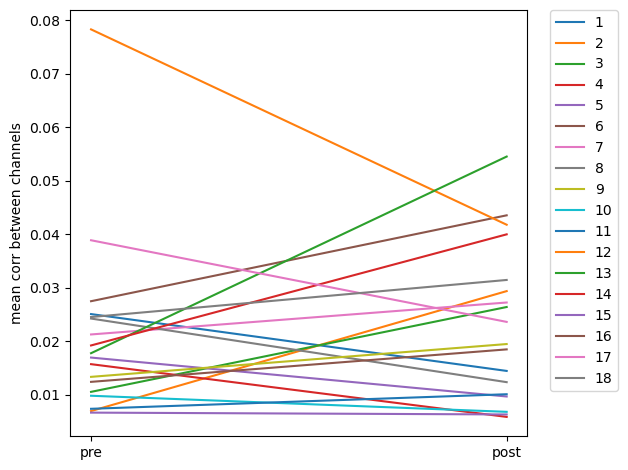

In [182]:
for i, subject in enumerate(subjects_to_process):
    plt.plot([1, 2], [corr_pre[i], corr_post[i]], label=i + 1)

plt.xticks([1, 2], ['pre', 'post'])
plt.ylabel('mean corr between channels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()


Correlation with performance scores

In [183]:
scores_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/training_scores_rank.csv')
corr_df = pd.DataFrame({'subject': subjects_to_process, 'corr_pre': corr_pre, 'corr_post': corr_post})


In [184]:
scores_df['subject'] = scores_df['subject'].astype(str).str.zfill(2)

In [185]:
scores_df['subject']

0     13
1     18
2     15
3     02
4     12
5     03
6     17
7     14
8     10
9     09
10    21
11    07
12    06
13    08
14    19
15    20
16    01
17    05
18    16
19    04
20    11
Name: subject, dtype: object

In [186]:
corr_df_merged = scores_df.merge(corr_df, on = ['subject'], how='left')
corr_df_merged['corr_diff'] = corr_df_merged['corr_post'] - corr_df_merged['corr_pre']

In [187]:
corr_df_merged

,Unnamed: 0,subject,score,musician,rank,corr_pre,corr_post,corr_diff
0,0,13,3.903614,1,1,0.078315,0.041800,-0.036516
1,1,18,3.855422,1,2,0.012430,0.018500,0.006070
2,2,15,3.783133,1,3,0.019237,0.040004,0.020767
3,3,02,3.698795,1,4,NaN,NaN,NaN
4,4,12,3.674699,1,5,0.007396,0.010117,0.002721
5,5,03,3.469880,0,6,0.006974,0.029394,0.022420
6,6,17,3.421687,1,7,NaN,NaN,NaN
7,7,14,3.409639,1,8,0.017788,0.054543,0.036755
8,8,10,3.373494,0,9,0.013366,0.019498,0.006132
9,9,09,3.325301,0,10,0.024265,0.012375,-0.011890


Text(0.5, 0, 'training score')

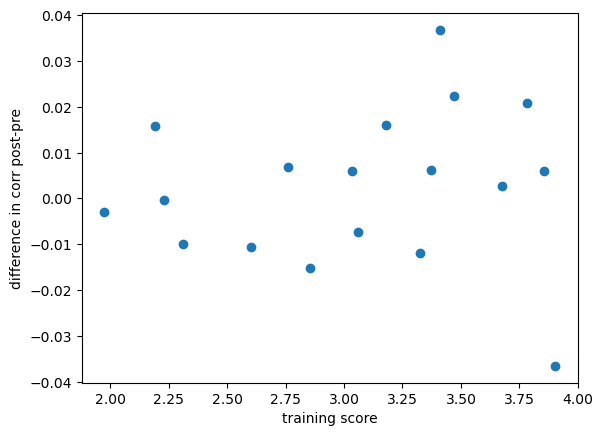

In [188]:
plt.scatter(corr_df_merged['score'], corr_df_merged['corr_diff'])
plt.ylabel('difference in corr post-pre')
plt.xlabel('training score')

In [189]:

# Calculate the Pearson correlation
import scipy.stats as stats
correlation, p_value = stats.pearsonr(cleaned_df['score'], cleaned_df['corr_diff'])

print(f"Pearson correlation: {correlation}")
print(f"P-value: {p_value}")


Pearson correlation: 0.42516801018213435
P-value: 0.0785927043284935


In [190]:
import scipy.stats as stats
correlation, p_value = stats.pearsonr(corr_df_merged['score'], corr_df_merged['corr_diff'])

print(f"Pearson correlation: {correlation}")
print(f"P-value: {p_value}")

ValueError: array must not contain infs or NaNs

In [ ]:
def bootstrap_corr(B, x, y, alpha=0.05, test = pearsonr):
    """
    Compute bootstrap confidence intervals and p-value for the correlation coefficient.

    Parameters:
    - B: int, number of bootstrap samples (e.g., B=1000)
    - x: array-like, first variable
    - y: array-like, second variable
    - alpha: float, significance level (e.g., alpha=0.05)

    Returns:
    - p: float, p-value for the observed correlation coefficient
    - ci: tuple, confidence interval for the correlation coefficient
    """
    # Observed correlation coefficient
    obs_corr, obs_p = test(x, y)

    # Bootstrap resampling
    n = len(x)
    boot_corr = np.empty(B)
    p_corr = np.empty(B)
    for i in range(B):
        indices = np.random.choice(n, n, replace=True)
        boot_corr[i], p_corr[i] = test(x[indices], y[indices])

    # Calculate confidence interval
    ci = np.percentile(boot_corr, [100 * alpha / 2, 100 * (1 - alpha / 2)])

    # Calculate p-value
    p = 2 * min(np.mean(boot_corr >= obs_corr), np.mean(boot_corr <= -obs_corr))

    # Calculate p-value
    #p_upper = np.mean(boot_corr >= obs_corr)
    #p_lower = np.mean(boot_corr <= -obs_corr)
    #p = p_upper + p_lower  # Combine both tails


    # Plot histogram of bootstrap correlations
    plt.figure()
    plt.hist(boot_corr, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(obs_corr, color='red', linewidth=2, label=f'Sample Correlation ({obs_corr:.3f})')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Bootstrap Distribution of Correlation')
    plt.legend()
    plt.show()

    # Display results
    print('Bootstrap Estimates:')
    print(f'Correlation coefficient: {obs_corr:.3f}, p = {obs_p}')
    print(f'p-value: {p:.7f}')
    print(f'{(1 - alpha) * 100:.1f}% Confidence Interval: [{ci[0]:.3f}, {ci[1]:.3f}]')
    print(f'bootstrap corr: {boot_corr.mean()}, ave_p = {p_corr.mean()}')

    return p, ci, boot_corr, p_corr



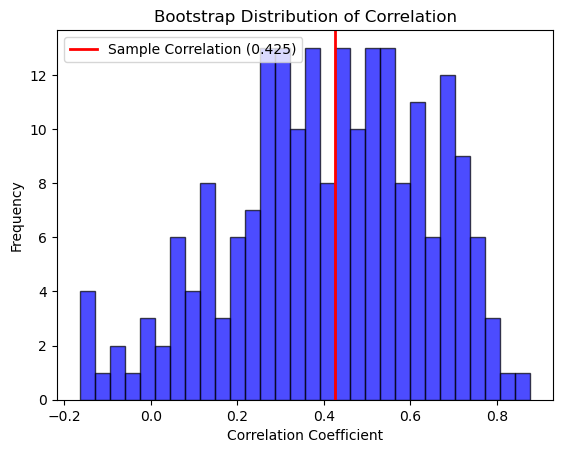

Bootstrap Estimates:
Correlation coefficient: 0.425, p = 0.0785927043284935
p-value: 0.0000000
95.0% Confidence Interval: [-0.087, 0.765]
bootstrap corr: 0.4097496773831021, ave_p = 0.199668412086803


In [ ]:
cleaned_df = corr_df_merged.dropna(subset=['score', 'corr_diff']).reset_index(drop=True)

p, ci, boot_corr, p_corr = bootstrap_corr(210, cleaned_df['score'], cleaned_df['corr_diff'], alpha=0.05, test =pearsonr)

Correlation with phase shift